In [1]:
import json
import matplotlib.pyplot as plt
%matplotlib inline
from typing import Optional
import numpy as np
import os
from strawberryfields.backends.tfbackend.states import FockStateTF
from math import exp
from src.utils import von_neumann_entropy, renyi_entropy

2023-03-15 11:42:55.606240: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 11:42:55.750305: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 11:42:55.750337: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-15 11:42:56.450235: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import atan2, degrees
import copy
from cycler import cycler

golden_mean = (np.sqrt(5.0)-1.0)/2.0

subplotlabelfont = {#'family': 'Helvetica',
        'fontweight': 'bold',
        'fontsize': 9
        }

def format_axes(axes, position=(-.1, 1.02)):
    for i, ax in enumerate(axes, start=97):
        ax.text(*position, chr(i), fontdict=subplotlabelfont, weight='bold',
                transform=ax.transAxes)

def figsize(scale, aspect_ratio = golden_mean):
    fig_width_pt = 246.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch

    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = fig_width*aspect_ratio              # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

rcparams = {                      # setup matplotlib to use latex for output
    #"text.usetex": False,                # use LaTeX to write all text
    #"font.family": "sans-serif",
    #"font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    #"font.sans-serif": ["Helvetica"],
    #"font.monospace": [],
    "axes.labelsize": 12,               # LaTeX default is 10pt font.
    "axes.linewidth": 2,
    'lines.linewidth': 2,
    "xtick.major.width": 2,
    "ytick.major.width": 2,
    "lines.markersize":2,
    "font.size": 9,
    "legend.fontsize": 10,               # Make the legend/label fonts a little smaller
    #"axes.spines.top": False,
    #"axes.spines.right": False,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize(1.5),     # default fig size of 0.9 textwidth
#    "mathtext.fontset" : "custom",
#     "mathtext.rm" :  "Helvetica",
#     "mathtext.it" :  "Helvetica:italic",
#     "mathtext.bf" :  "Helvetica:bold",
#     "mathtext.sf" :  "Helvetica",
#     "mathtext.tt" :  "DejaVu Sans",
#     "mathtext.cal" : "DejaVu Sans:italic",
    }

mpl.rcParams.update(rcparams)

#Grad = ['#03fc28','#b503fc','#ff0000','#f5b942','#00ffaf','#FFAEBC','#B4F8C8','#C70039','#FFA500','#ffe800','#ff0078', '#00ffba','#1f52fe','#ff9600']
            
#mpl.rcParams['axes.prop_cycle'] =cycler(color=Grad)
dt=1e-3
steps=int(2e5)
x=np.array(list(range(0,steps)))*dt
a=1
a2=.4

plt.style.use(['seaborn-whitegrid'])#(['Solarize_Light2'])

In [19]:
dir = 'logs/2023.02.21.13.19.23'
plots_path = os.path.join('./latex', 'figures')
os.makedirs(plots_path, exist_ok=True)
res = np.load(os.path.join(dir, 'results.npy'))
starting_distance = 0

binding_energies = res[:, starting_distance:, -1, -1]
states = res[:, starting_distance:, :-1, :-1]
distances = np.load(os.path.join(dir, 'distance_array.npy'))[starting_distance:]
thetas = np.load(os.path.join(dir, 'angle_array.npy'))
quadrature_grid = np.load(os.path.join(dir, 'quadrature_array.npy'))
entropy_array = von_neumann_entropy(states=states)
renyi_entropy_array = renyi_entropy(states=states, n=2)
correlation_array = np.load(os.path.join(dir, 'correlation_array.npy'))
startingDistance = [1, 2, 3, 5, 7, 8, 10, 12, 15, 18, 24, 22, 18, 17, 17, 16, 21, 25, 24] # starting at the first non-parallel angle

with open(os.path.join(dir, 'args.json')) as f:
    args = json.load(f)

In [20]:
def entropy_fit(r):
    expr = (1354.1190287327627 + 69.57059464705372/r**6 - 589.0017867913149/r**5 + 2177.9948912201044/r**4 - 4485.60849646864/r**3 + 5528.745912907768/r**2 - 3988.1254971335707/r + 203.0086635377917*r - 420.62415056426846*r**2 + 192.6852057844995*r**3 - 45.45103486645947*r**4 + 5.6428967627556075*r**5 - 0.292282473955571*r**6)/(-1 + exp(3.340009074510866/r))
    
    return expr

def fit_morse_quality(r):
    return 0.7562780555949897/exp(7.90810731120047*r)


def correlation_fit(r):
    def k(x, y, sigma):
        return exp(-(x - y)**2 / (2 * sigma**2))
    
    sigma = 0.04
    up = 0
    down = 0

    start = startingDistance[7]

    for i in range(distances[start:].shape[0]):
        up += k(r, distances[start:][i], sigma) * correlation_array[7][start:][i]
        down += k(r, distances[start:][i], sigma)
 
    return up / down

def interpolation_morse(r, angle_idx):
    r'''
    These are the Morse potential fit obtained in Mathematica
    '''
    
    if angle_idx == 1:
        expr = 5.580390309448237*(exp(-3.0377471897088193*(-0.528669782788294 + r)) - 2/exp(1.5188735948544096*(-0.528669782788294 + r)))
    elif angle_idx == 2:
        expr = 3.4274486627573997*(exp(-3.799380158605931*(-0.47973290114432926 + r)) - 2/exp(1.8996900793029654*(-0.47973290114432926 + r)))
    elif angle_idx == 3:
        expr = 2.285401169096024*(exp(-4.402463155249511*(-0.4631079255337017 + r)) - 2/exp(2.2012315776247555*(-0.4631079255337017 + r)))
    elif angle_idx == 4:
        expr = 1.551192171427588*(exp(-4.81570374860555*(-0.4642655447957261 + r)) - 2/exp(2.407851874302775*(-0.4642655447957261 + r)))
    elif angle_idx == 5:
        expr = 1.0598470742964785*(exp(-5.1410754088615755*(-0.4783898190284267 + r)) - 2/exp(2.5705377044307878*(-0.4783898190284267 + r)))
    elif angle_idx == 6:
        expr = 0.7148220809706628*(exp(-5.3904241278507286*(-0.5018955265663114 + r)) - 2/exp(2.6952120639253643*(-0.5018955265663114 + r)))
    elif angle_idx == 7:
        expr = 0.46331721539795195*(exp(-5.5069105743552305*(-0.5384565406606292 + r)) - 2/exp(2.7534552871776152*(-0.5384565406606292 + r)))
    elif angle_idx == 8:
        expr = 0.28495211368558043*(exp(-5.501660360933069*(-0.5868720195028256 + r)) - 2/exp(2.7508301804665347*(-0.5868720195028256 + r)))
    elif angle_idx == 9:
        expr = 0.16054553861792828*(exp(-5.406762370032314*(-0.6589019567964931 + r)) - 2/exp(2.703381185016157*(-0.6589019567964931 + r)))
    elif angle_idx == 10:
        expr = 0.0802423625900907*(exp(-5.2807411035440905*(-0.7610680973692473 + r)) - 2/exp(2.6403705517720453*(-0.7610680973692473 + r)))
    elif angle_idx == 11:
        expr = 0.031941895762222915*(exp(-4.8881023079372845*(-0.9318352120398004 + r)) - 2/exp(2.4440511539686423*(-0.9318352120398004 + r)))
    elif angle_idx == 12:
        expr = -0.21795992863678978*(exp(-18.93357243882598*(-0.419031099683263 + r)) - 2/exp(9.46678621941299*(-0.419031099683263 + r)))
    elif angle_idx == 13:
        expr = -4.596185038513766e8*(exp(-11.486738219445648*(3.3611808687392295 + r)) - 2/exp(5.743369109722824*(3.3611808687392295 + r)))
    elif angle_idx == 14:
        expr = -8.435877205314344e8*(exp(-9.835982910255005*(4.090374604186538 + r)) - 2/exp(4.917991455127503*(4.090374604186538 + r)))
    elif angle_idx == 15:
        expr = -5595.4996148289965*(-2*exp(3.473725867625206e-6*(199537.59265461436 + r)) + exp(6.947451735250412e-6*(199537.59265461436 + r)))
    elif angle_idx == 16:
        expr = -6257.5024012085705*(-2*exp(3.613860552846493e-6*(191800.01322388317 + r)) + exp(7.227721105692986e-6*(191800.01322388317 + r)))
    elif angle_idx == 17:
        expr = -78.2709544530638*(exp(-7.326961784623224*(1.1821855753944306 + r)) - 2/exp(3.663480892311612*(1.1821855753944306 + r)))
    elif angle_idx == 18:
        expr = -60.335480736907535*(exp(-6.655169258297058*(1.283760988719811 + r)) - 2/exp(3.327584629148529*(1.283760988719811 + r)))
    elif angle_idx == 19:
        expr = -59.1291656257202*(exp(-6.735608158749974*(1.248561482832166 + r)) - 2/exp(3.367804079374987*(1.248561482832166 + r)))
    return expr

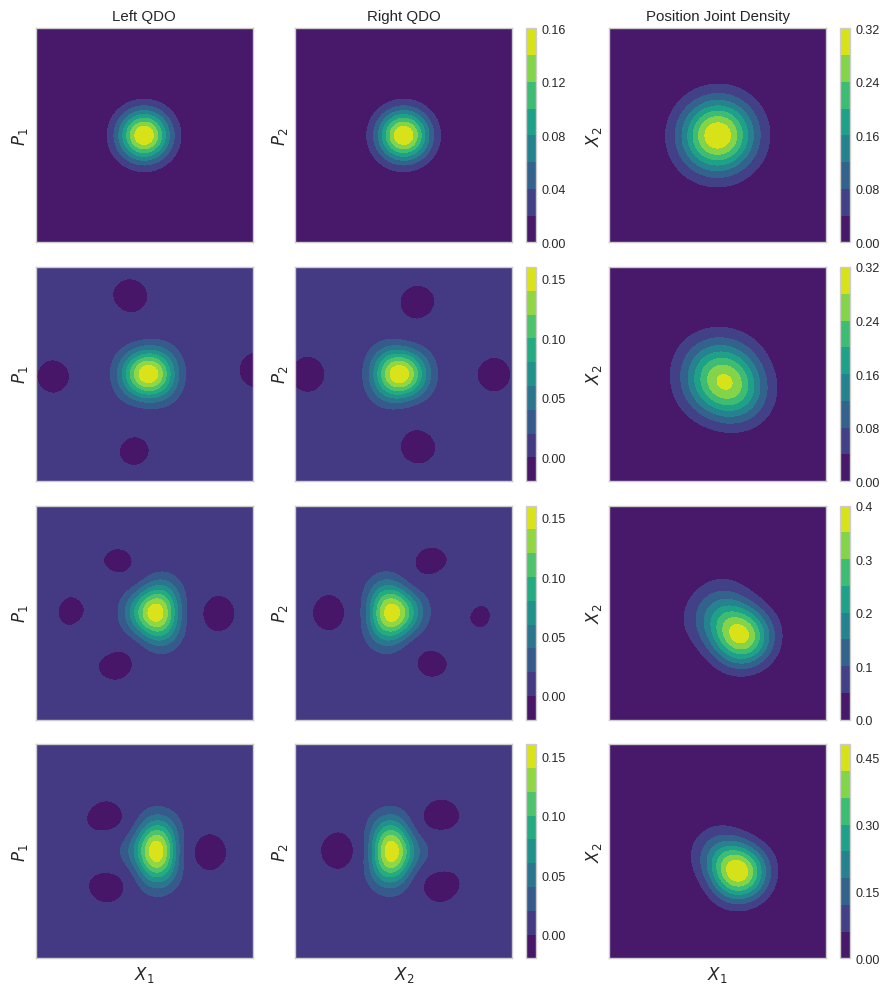

In [21]:
from src.utils import quadratures_density
import copy
cmappa = 'viridis'
#cmappa = 'GnBu'
def plot_wigner(
    fig_dir: Optional[str],
    quadrature_grid: np.ndarray,
    states: np.ndarray,
    cutoff_dim: int = 5
) -> None:

    X, P = np.meshgrid(quadrature_grid, quadrature_grid)
    
    X1, X2 = np.meshgrid(quadrature_grid, quadrature_grid)

    state0 = FockStateTF(state_data=states[7, 180], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state1 = FockStateTF(state_data=states[7, 72], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state2 = FockStateTF(state_data=states[7, 42], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    state3 = FockStateTF(state_data=states[7, 26], num_modes=2, pure=True, cutoff_dim=cutoff_dim)
    w_qdo1_0 = state0.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_0 = state0.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_1 = state1.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_1 = state1.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_2 = state2.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_2 = state2.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo1_3 = state3.wigner(mode=0, xvec=quadrature_grid, pvec=quadrature_grid)
    w_qdo2_3 = state3.wigner(mode=1, xvec=quadrature_grid, pvec=quadrature_grid)
    
    # large distance
    joint_density0 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 180],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # intermediate distance
    joint_density1 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 72],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # max entropy
    joint_density2 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 42],
        num_modes=2,
        cutoff=cutoff_dim
    )

    # bound state
    joint_density3 = quadratures_density(
        x=quadrature_grid,
        alpha=states[7, 26],
        num_modes=2,
        cutoff=cutoff_dim
    )

    fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 10), sharex=False, sharey=False, gridspec_kw={'width_ratios': [.8, 1, 1]})

    heatmap1_0 = axes[0, 0].contourf(X, P, w_qdo2_0, cmap = cmappa)
    axes[0, 0].set_title("Left QDO")
    heatmap2_0 = axes[0, 1].contourf(X, P, w_qdo1_0, cmap = cmappa)
    axes[0, 1].set_title("Right QDO")
    cbar = plt.colorbar(heatmap2_0, ax=axes[0,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_0 = axes[0, 2].contourf(X1, X2, joint_density0, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_0, ax=axes[0,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[0, 2].set_title("Position Joint Density")
    axes[0, 0].set_ylabel(r"$d = 3.16$")

    heatmap1_1 = axes[1, 0].contourf(X, P, w_qdo2_1, cmap = cmappa)
    axes[1,0].set_ylabel('Y')
    heatmap2_1 = axes[1, 1].contourf(X, P, w_qdo1_1, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_1, ax=axes[1,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_1 = axes[1, 2].contourf(X1, X2, joint_density1, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_1, ax=axes[1,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[1, 0].set_ylabel(r"$d = 1.36$")

    heatmap1_2 = axes[2, 0].contourf(X, P, w_qdo2_2, cmap = cmappa)
    heatmap2_2 = axes[2, 1].contourf(X, P, w_qdo1_2, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_2, ax=axes[2,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_2 = axes[2, 2].contourf(X1, X2, joint_density2, cmap = cmappa)
    cbar = plt.colorbar(heatmap3_2, ax=axes[2,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[2, 0].set_ylabel(r"$d = 0.82$")

    heatmap1_3 = axes[3, 0].contourf(X, P, w_qdo2_3, cmap = cmappa)
    axes[3,0].set_ylabel('Y')
    heatmap2_3 = axes[3, 1].contourf(X, P, w_qdo1_3, cmap = cmappa)
    cbar = plt.colorbar(heatmap2_3, ax=axes[3,1])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    heatmap3_3 = axes[3, 2].contourf(X1, X2, joint_density3, cmap = cmappa)
    
    cbar = plt.colorbar(heatmap3_3, ax=axes[3,2])
    cbar.ax.tick_params(labelsize=9)
    cbar.locator = plt.MaxNLocator(4)
    cbar.update_ticks()
    axes[3, 0].set_ylabel(r"$d = 0.54$")

    for i in range(0,4):
        axes[i, 2].set_xlim(-3,3)
        axes[i, 2].set_ylim(-3,3)
        axes[i,0].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,1].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,2].yaxis.set_major_locator(plt.MaxNLocator(3))
        axes[i,0].set_ylabel(r'$P_1$')
        axes[i,1].set_ylabel(r'$P_2$')
        axes[i,2].set_ylabel(r'$X_2$')
        for j in range(0,3):
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
        
    axes[3,0].set_xlabel(r'$X_1$')
    axes[3,1].set_xlabel(r'$X_2$')
    axes[3,2].set_xlabel(r'$X_1$')

    fig.tight_layout(pad=1.0)
    #fig.subplots_adjust(right=0.8)
    #cbar_ax = fig.add_axes([0.83, 0.15, 0.02, 0.7])
    

    # fig.text(0.5, 0.04, 'Position quadrature', ha='center', fontdict={'fontsize':20})
    # fig.text(0.04, 0.5, 'Momentum quadrature', va='center', rotation='vertical')

    #plt.suptitle(r"$\theta$=0.58rad")
    plt.savefig(os.path.join(plots_path, 'wigners_joint.pdf'), dpi=300, transparent=False, bbox_inches='tight')


plot_wigner(
    fig_dir=None,
    quadrature_grid=quadrature_grid,
    states=states,
    cutoff_dim=args['cutoff_dim']
)

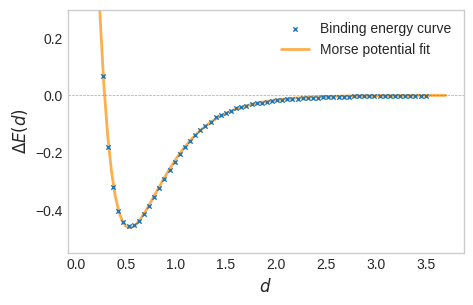

In [22]:
def plot_binding_curve_morse(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angle_idx: int,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1)

    line1, = axes.plot(
        np.linspace(0.1, 3.7, 100), 
        [interpolation_morse(r, angle_idx) for r in np.linspace(0.1, 3.7, 100)], 
        c='darkorange',
        alpha=0.7,
        label='Morse potential fit', 
        zorder=1
        
    )

    line0 = axes.scatter(
        distance_array[startingDistance[angle_idx-1]::3], 
        binding_energy_array[angle_idx, startingDistance[angle_idx-1]::3], 
        s=10, 
        marker='x',
        alpha=1,
        label='Binding energy curve', 
        zorder=2,
        linewidths=1
    )

    axes.axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes.set_xlabel(r'$d$')
    axes.set_ylabel(r'$\Delta E (d)$')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(False)
    #axes.set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes.legend(handles=[line0, line1])
    #plt.show()
    plt.savefig(os.path.join(plots_path, 'binding.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_curve_morse(
    distance_array=distances,
    binding_energy_array=binding_energies,
    ymin=-0.55,
    ymax=0.3,
    angle_idx=7
)

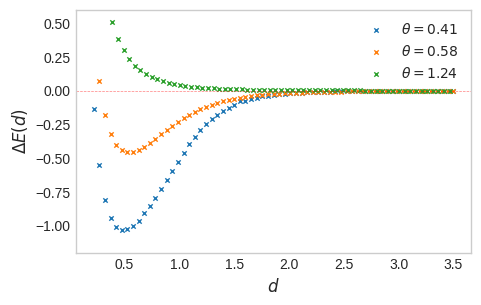

In [67]:
def plot_binding_multiple_binding_curves(
    distance_array: np.ndarray,
    binding_energy_array: np.ndarray,
    angles: list,
    ymin: Optional[float]=None,
    ymax: Optional[float]=None
) -> None:

    fig, axes = plt.subplots(nrows=1, ncols=1)

    every = 3

    angle_idx0 = angles[0]
    line0 = axes.scatter(
        distance_array[startingDistance[angle_idx0-1]::every], 
        binding_energy_array[angle_idx0, startingDistance[angle_idx0-1]::every], 
        s=10, 
        marker='x',
        alpha=1,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx0]), 
        zorder=2,
        linewidths=1
    )
    
    angle_idx1 = angles[1]
    line1 = axes.scatter(
        distance_array[startingDistance[angle_idx1-1]::every], 
        binding_energy_array[angle_idx1, startingDistance[angle_idx1-1]::every], 
        s=10, 
        marker='x',
        alpha=1,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx1]),  
        zorder=2,
        linewidths=1
    )

    angle_idx2 = angles[2]
    line2 = axes.scatter(
        distance_array[startingDistance[angle_idx2-1]::every], 
        binding_energy_array[angle_idx2, startingDistance[angle_idx2-1]::every], 
        s=10, 
        marker='x',
        alpha=1,
        label=r'$\theta={:.2f}$'.format(thetas[angle_idx2]), 
        zorder=2,
        linewidths=1
    )

    axes.axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )
    
    axes.set_xlabel(r'$d$')
    axes.set_ylabel(r'$\Delta E (d)$')
    if ymin is not None and ymax is not None:
        axes.set_ylim(ymin, ymax)
    axes.grid(False)
    #axes.set_title(r'Binding energy for a pair of QDOs at the optimal angle $\theta=0.57$ rad')
    axes.legend(handles=[line0, line1, line2])
    #plt.show()
    plt.savefig(os.path.join(plots_path, 'binding_vs_smooth.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_binding_multiple_binding_curves(
    distance_array=distances,
    binding_energy_array=binding_energies,
    angles=[5, 7, 15],
    ymin=-1.2,
    ymax=0.6,
)

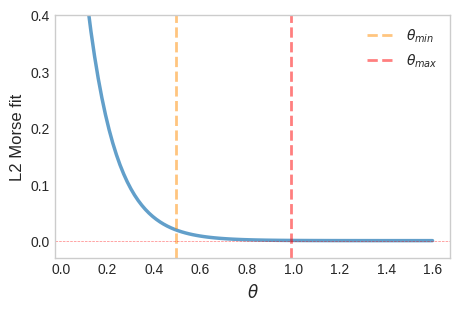

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=1)

line0, = axes.plot(
    np.linspace(0.05, 1.6, 100), 
    [fit_morse_quality(r) for r in np.linspace(0.01, 1.6, 100)], 
    #c='purple',
    alpha=0.7,
    #label='L2-error of the Morse fit',
    linewidth=2.5
)

line1 = axes.axvline(x=0.4960409453036515, label=r'$\theta_{min}$', c='darkorange', alpha=0.5, linestyle = 'dashed')
line2 = axes.axvline(x=0.992081890607303, label=r'$\theta_{max}$', c='red', alpha=0.5, linestyle = 'dashed')

axes.axhline(
    y = 0.0, 
    color = 'red', 
    linestyle = '--',
    alpha=0.5,
    lw=0.5
)

axes.legend(handles=[line0, line1, line2])

axes.set_xlabel(r'$\theta$')
axes.set_ylabel(r'L2 Morse fit')
axes.set_ylim(-0.03, 0.4)
axes.grid(False)
#axes.set_title('Morse fit quality as a function of the angle')
#plt.show()
plt.savefig(os.path.join(plots_path, 'morse_quality.pdf'), dpi=300, transparent=False, bbox_inches='tight')

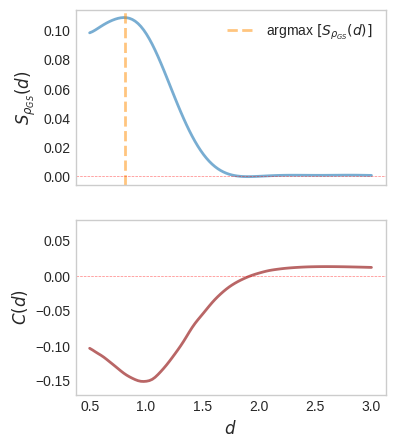

In [38]:
angle_idx = 7
start = startingDistance[angle_idx - 1] + 6

def plot_entropy(
    distance_array: np.ndarray,
    entropy_array: np.ndarray
) -> None:

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(4,5))
    #axes.scatter(distance_array[4:], binding_energy_array[4:], s=10)
    #axes.scatter(
    #    distance_array[start::3], 
    #    entropy_array[start::3],
    #    s=20, 
    #    c='darkblue', 
    #    marker='*',
    #    alpha=0.3
    #)
    line0, = axes[0].plot(
        np.linspace(0.5, 3.0, 100), 
        [entropy_fit(r) for r in np.linspace(0.5, 3.0, 100)], 
        alpha=0.6,
        #label=r'$S(\rho_{GS}(d))$',
        
        #linewidth=2
    )

    line1, = axes[1].plot(
        np.linspace(0.5, 3.0, 100), 
        [correlation_fit(r) for r in np.linspace(0.5, 3.0, 100)], 
        c='darkred',
        alpha=0.6,
        #label='Correlation coefficients',
        linewidth=2
    )

    #axes[0].set_xlabel(r'$d$')
    axes[0].set_ylabel(r'$S_{\rho_{GS}}(d)$')
    axes[0].grid(False)
    #axes.set_title('Entanglement entropy')

    line2 = axes[0].axvline(x=0.81758794, label=r'argmax $[S_{\rho_{GS}}(d)]$', linestyle = 'dashed', color = 'darkorange', alpha=0.5)
    axes[0].legend(handles=[line0, line2])
    
    axes[1].legend(handles=[line1])
    axes[1].set_xlabel(r'$d$')
    axes[1].set_ylabel(r'$C(d)$')
    axes[1].set_ylim(-0.17, 0.08)
    axes[1].grid(False)

    axes[0].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )

    axes[1].axhline(
        y = 0.0, 
        color = 'red', 
        linestyle = '--',
        alpha=0.5,
        lw=0.5
    )

    plt.savefig(os.path.join(plots_path, 'entropy_correlation.pdf'), dpi=300, transparent=False, bbox_inches='tight')

plot_entropy(
    distance_array=distances[start:],
    entropy_array=entropy_array[angle_idx, start:]
)

In [25]:
d = np.array(distances[startingDistance[5-1]::3])
be = np.real(binding_energies[5, startingDistance[5-1]::3])



In [26]:
def LJ(x, eps, sigma):
    return 4*eps*((sigma/x)**12 - (sigma/x)**6)

def LJ_exp(x, eps, alpha, sigma):
    return 4*eps*(np.exp(-alpha*x) - (sigma/x)**6)

def Morse(x, D, beta, Re):
    return D*(np.exp(-2*beta*(x-Re))-2*np.exp(-beta*(x-Re)))


Morse(d, 1, 1, 1)

array([ 0.39795014,  0.15199153, -0.05965058, -0.240837  , -0.3950265 ,
       -0.52531632, -0.6344786 , -0.72499321, -0.79907735, -0.85871221,
       -0.90566691, -0.94152016, -0.96767972, -0.98539988, -0.99579722,
       -0.99986486, -0.99848517, -0.99244126, -0.98242736, -0.96905805,
       -0.95287666, -0.93436278, -0.91393898, -0.89197691, -0.86880274,
       -0.84470205, -0.81992421, -0.79468637, -0.76917696, -0.74355887,
       -0.7179723 , -0.69253732, -0.66735615, -0.6425152 , -0.61808691,
       -0.59413139, -0.57069788, -0.54782605, -0.52554719, -0.50388524,
       -0.48285774, -0.46247662, -0.44274897, -0.42367769, -0.40526208,
       -0.38749833, -0.37038001, -0.35389847, -0.33804317, -0.32280206,
       -0.30816178, -0.29410798, -0.28062547, -0.26769847, -0.25531074,
       -0.24344571, -0.23208666, -0.22121675, -0.2108192 , -0.20087729,
       -0.19137448, -0.18229445, -0.17362114, -0.16533881, -0.15743205])

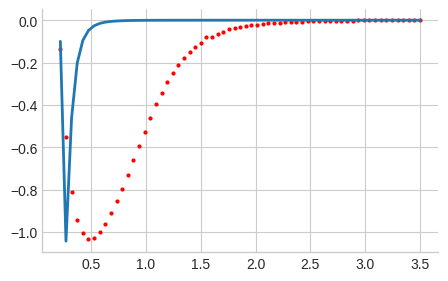

In [15]:
plt.plot(d, LJ(d,1.29809991, -0.21887476))
plt.scatter(d, be, c = 'r')


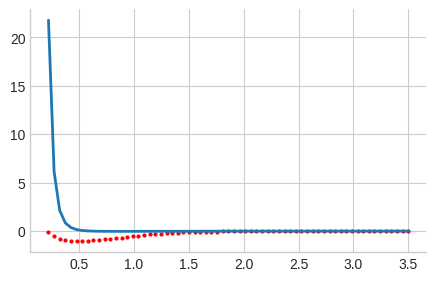

In [16]:
plt.plot(d, LJ_exp(d, -0.0240163 ,  1.24563151,  0.54246192))
plt.scatter(d, be, color = 'red')


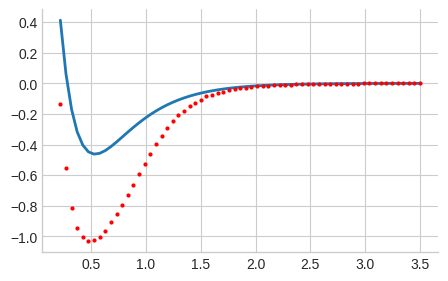

In [17]:
plt.plot(d, Morse(d, 0.46295854, 2.73239587, 0.5361966 ), zorder = 1)
plt.scatter(d, be, color = 'red',zorder = 2)


(array([2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 2.]),
 array([0.21959799, 0.27427136, 0.32894472, 0.38361809, 0.43829146,
        0.49296482, 0.54763819, 0.60231156, 0.65698492, 0.71165829,
        0.76633166, 0.82100503, 0.87567839, 0.93035176, 0.98502513,
        1.03969849, 1.09437186, 1.14904523, 1.20371859, 1.25839196,
        1.31306533, 1.36773869, 1.42241206, 1.47708543, 1.53175879,
        1.58643216, 1.64110553, 1.69577889, 1.75045226, 1.80512563,
        1.85979899, 1.91447236, 1.96914573, 2.0238191 , 2.07849246,
        2.13316583, 2.1878392 , 2.24251256, 2.29718593, 2.3518593 ,
        2.40653266, 2.46120603, 2.5158794 , 2.57055276, 2.62522613,
        2.6798995 , 2.73457286, 2.78924623, 2.8439196 , 2.89859296,
        2.95326633, 3.0079397 , 3.06261307, 3.

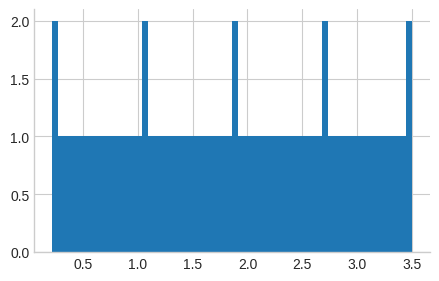

In [18]:
plt.hist(d, bins = 60)

In [88]:
from scipy.optimize import curve_fit
f = curve_fit(LJ, d, be, method = 'lm', maxfev = 10000)

In [89]:
f

(array([ 1.29809991, -0.21887476]),
 array([[2.00174367e-01, 9.64693046e-05],
        [9.64693046e-05, 8.78349611e-06]]))